## Some imports and installation

In [ ]:
# !rm -r SPV

In [1]:
!pip install -q ultralytics==8.0.28 roboflow gdown segmentation-models-pytorch pytorch-lightning

# Get data
!gdown https://drive.google.com/uc?id=1wcTQvS8m6pg09hhMSxjbA-RKyU_80e7L
!unzip -q ./spv.zip -d .

# Get repo
!git clone https://github.com/asartipi13/SPV.git

# Test picture
!wget 'https://media.licdn.com/dms/image/D5622AQHlUirpkNS5aw/feedshare-shrink_800/0/1682643405952?e=1686787200&v=beta&t=31OiUuMdno3jkD2wF0T3wavXD2SRkeCsB-d8wJm5ebE'  -O test.jpeg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.2 MB/s eta

In [2]:
import os, json
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from pprint import pprint
from torch.utils.data import DataLoader

In [3]:
# My codes
from SPV.spv_dataloader import SimpleSolarPVDataset
from SPV.model import SolarModel
from SPV.utils import visualize, aggregate_dict

## Dataset

In [4]:
root = "./spv"

train_dataset = SimpleSolarPVDataset(root, "train")
valid_dataset = SimpleSolarPVDataset(root, "valid")
test_dataset = SimpleSolarPVDataset(root, "test")

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Train size: 1428
Valid size: 85
Test size: 69


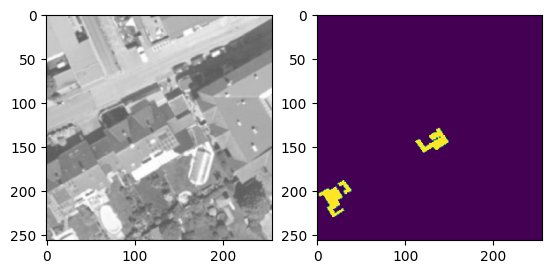

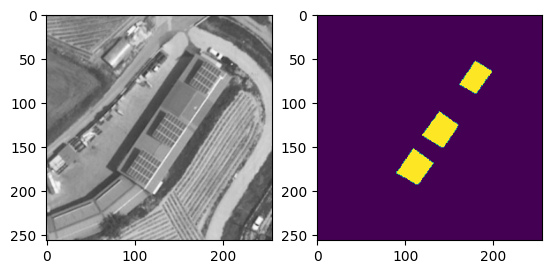

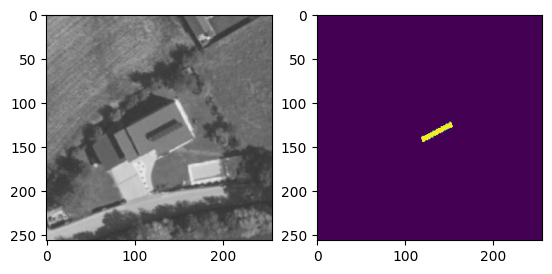

In [5]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

## Model

In [6]:
# possible values for neural net (arch) are: "FPN", "PSPNet", "Unet", "DeepLabV3", "PAN", "Linknet", "MAnet", "Unet++", "DeepLabV3+"
net = "MAnet"

if not os.path.exists(net):
  os.makedirs(net)
  
model = SolarModel(arch=net, encoder_name="resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 145MB/s]


## Training

In [7]:
trainer = pl.Trainer(
    max_epochs=25,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | MAnet    | 31.8 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
31.8 M    Trainable params
0         Non-trainable params
31.8 M    Total params
127.135   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


## Train results

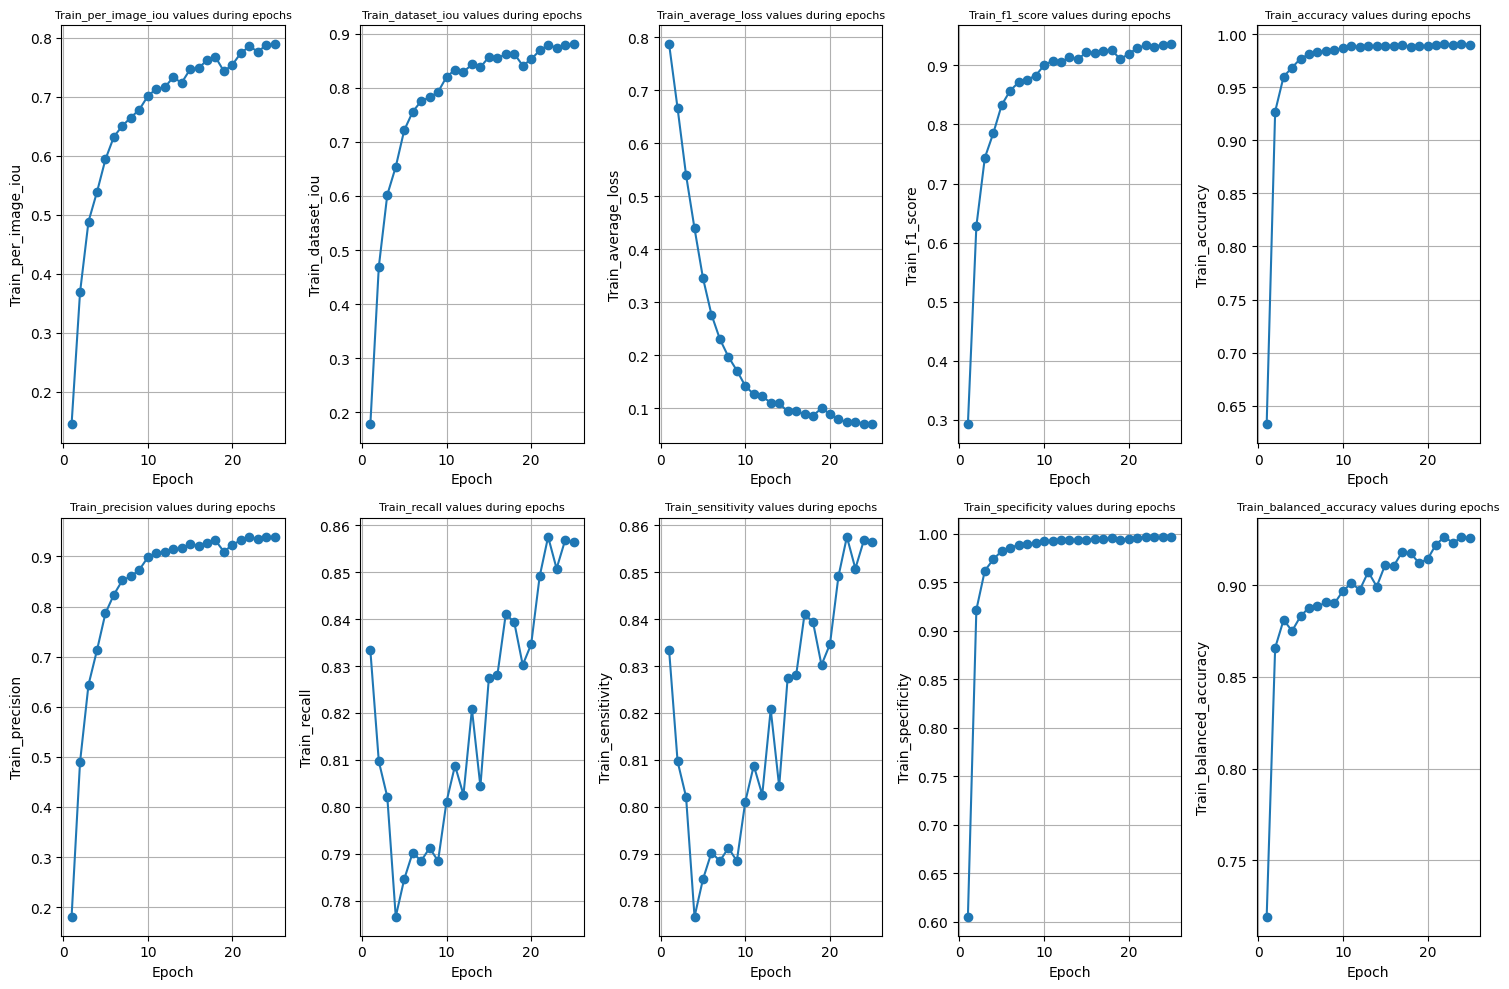

In [8]:
group_size = 90
model.train_results = aggregate_dict(model.train_results, group_size)
visualize(model.train_results, 'train', net)

## Validation results

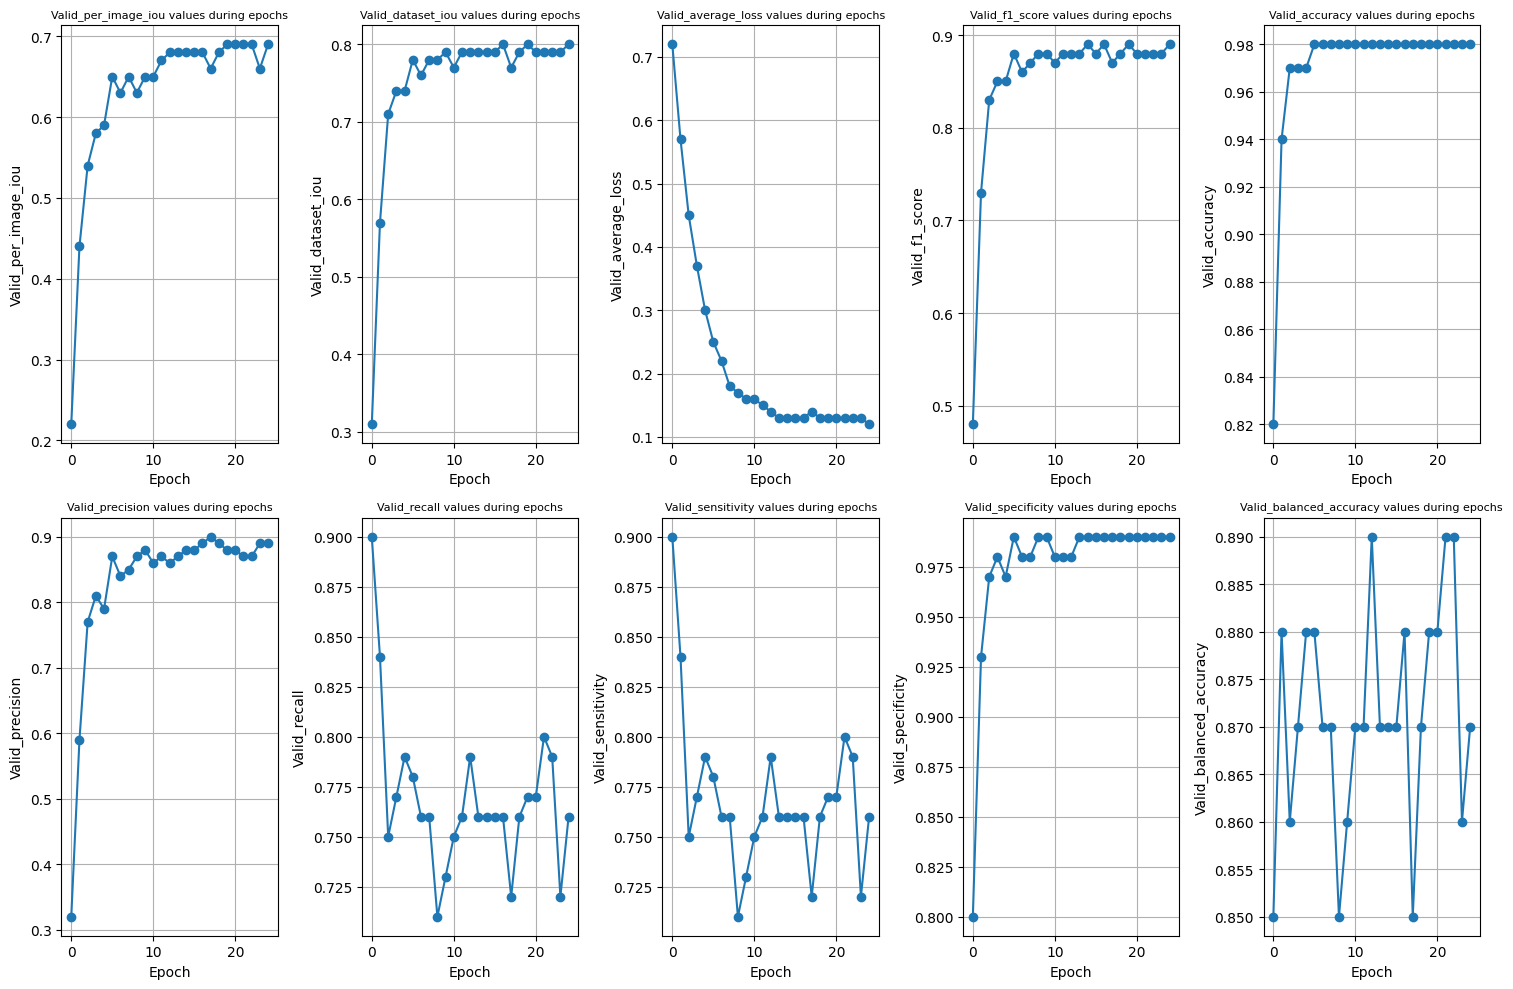

In [9]:
visualize(model.val_results, 'val', net) 

In [10]:
# Dump the dictionary to a JSON file
save_path_train = f"train-{net}.json"
save_path_val = f"val-{net}.json"

with open(os.path.join(net, save_path_train), "w") as file:
    json.dump(model.train_results, file)
with open(os.path.join(net, save_path_val), "w") as file:
    json.dump(model.val_results, file)


In [11]:
# run validation and test dataset
# trainer.validate(model, dataloaders=valid_dataloader, verbose=True)
# trainer.test(model, dataloaders=test_dataloader, verbose=True)

# Result visualization

In [12]:
def test_dataset(test_dataloader, model, neural_net_name):
  batch = next(iter(test_dataloader))
  with torch.no_grad():
      model.eval()
      logits = model(batch["image"])
  pr_masks = logits.sigmoid()
  if not os.path.exists(os.path.join(neural_net_name, 'test-out')):
    os.makedirs(os.path.join(neural_net_name, 'test-out'))
    
  for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch["image"], batch["mask"], pr_masks)):
      plt.figure(figsize=(10, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
      plt.title("Image")
      plt.axis("off")

      plt.subplot(1, 3, 2)
      plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
      plt.title("Ground truth")
      plt.axis("off")

      plt.subplot(1, 3, 3)
      plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
      plt.title("Prediction")
      plt.axis("off")
      plt.savefig(os.path.join(os.path.join(neural_net_name, "test-out"),  str(idx)+ neural_net_name))
      plt.show()


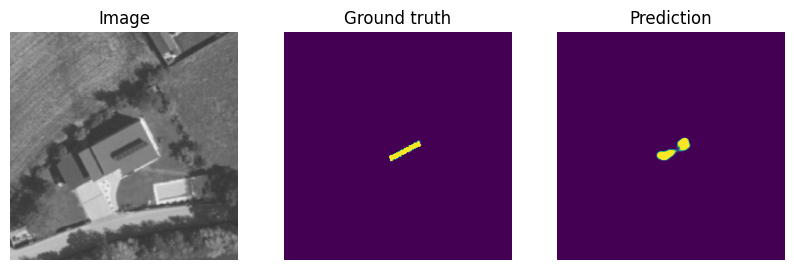

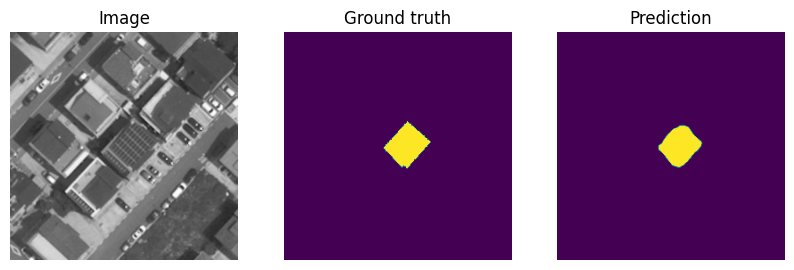

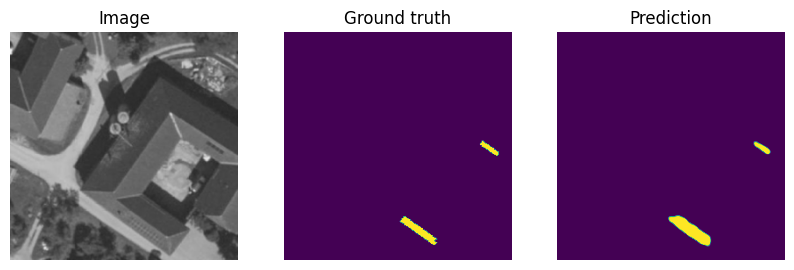

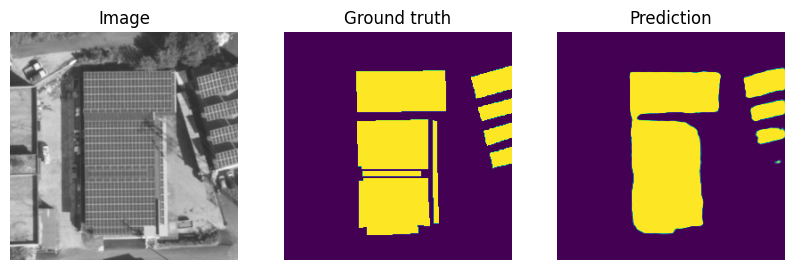

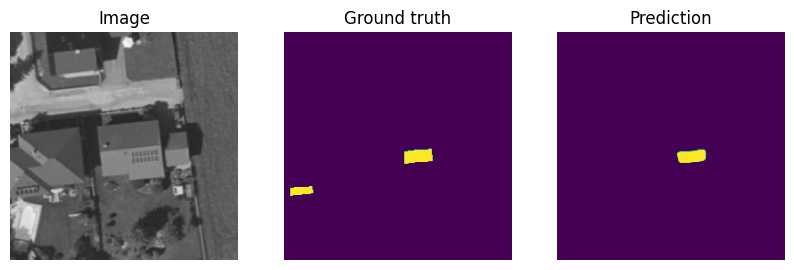

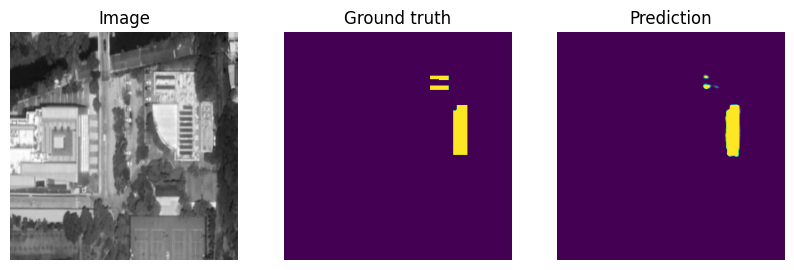

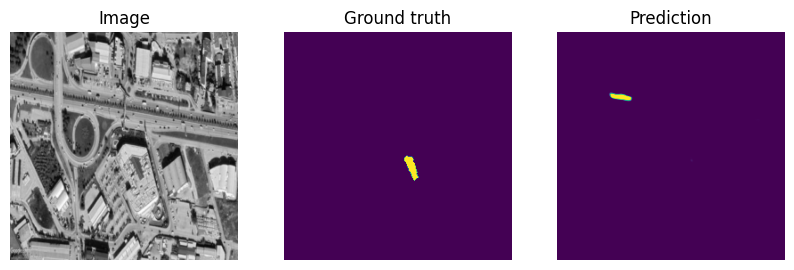

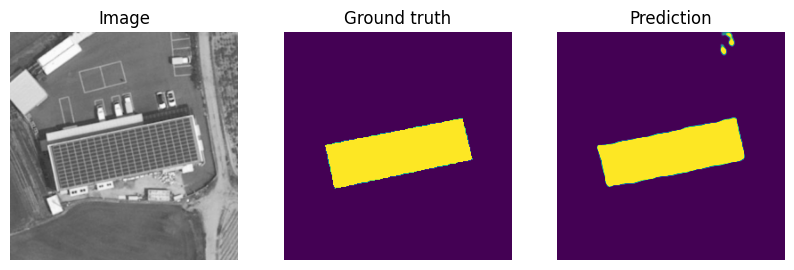

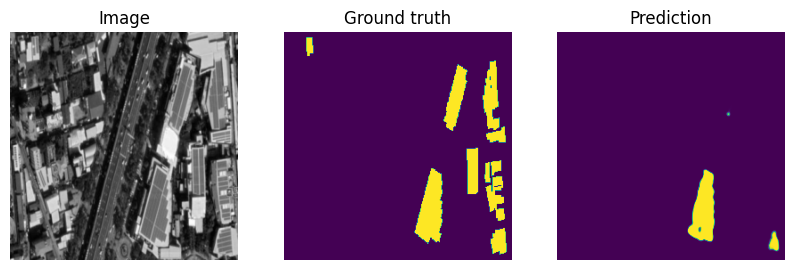

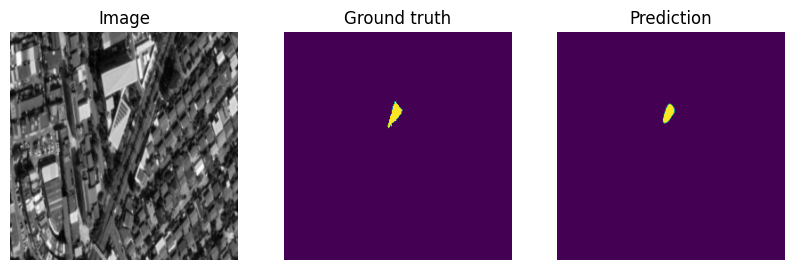

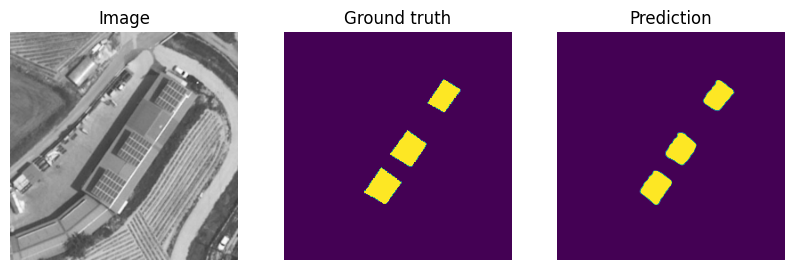

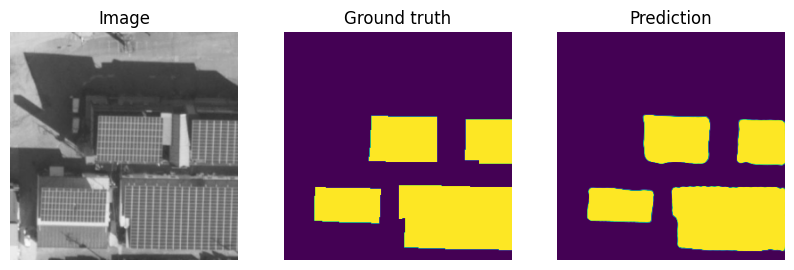

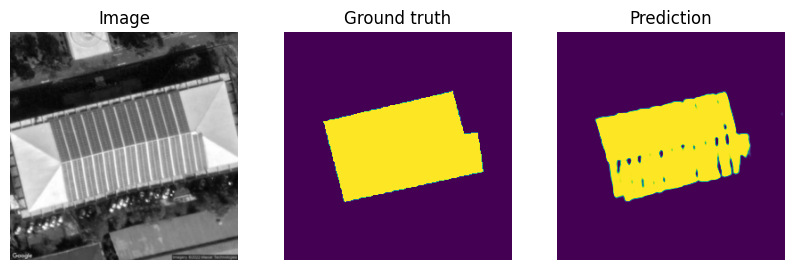

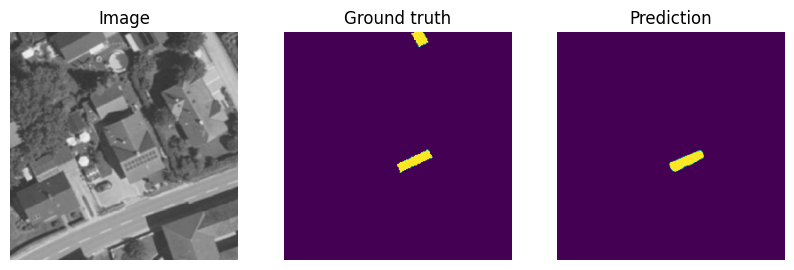

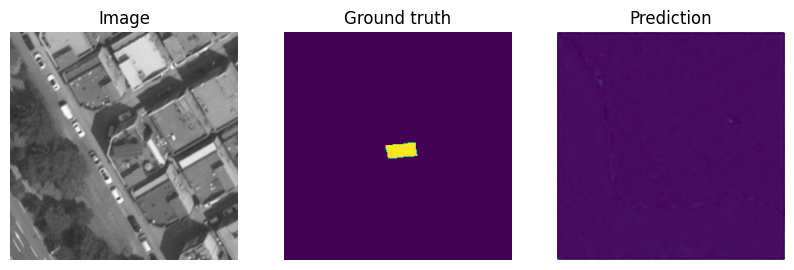

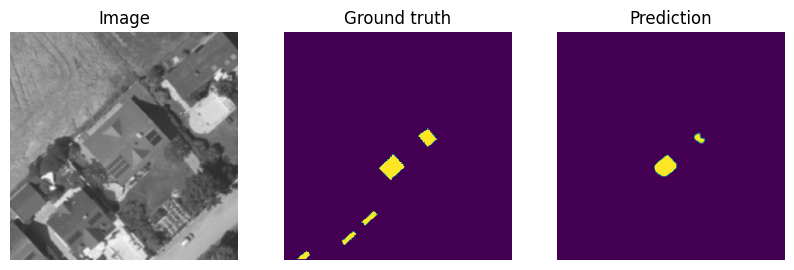

In [13]:
test_dataset(test_dataloader, model, neural_net_name=net)

## Test the picture

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

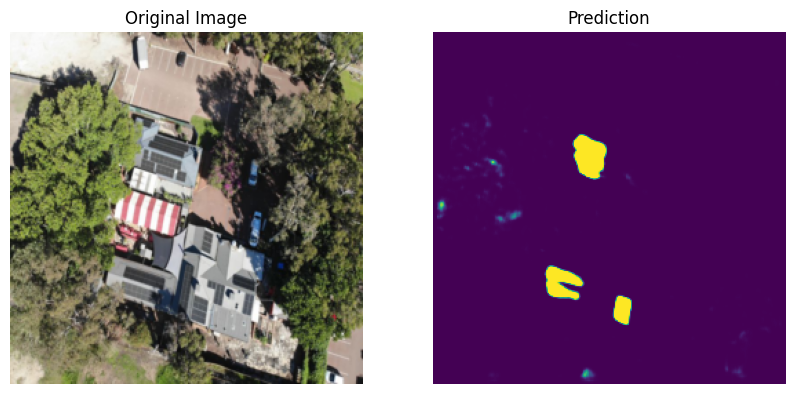

In [15]:
# Load and preprocess the image
image = np.array(Image.open("./test.jpeg").convert("RGB"))
image = np.array(Image.fromarray(image).resize((256, 256), Image.LINEAR))
image = np.moveaxis(image, -1, 0)

# Pass the preprocessed image through the model
logits = model(torch.tensor(image))
pr_mask2 = logits.sigmoid()

# Display the original image and the prediction
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axs[0].imshow(image.squeeze().transpose(1, 2, 0))
axs[0].set_title("Original Image")
axs[0].axis("off")

# Prediction
axs[1].imshow(pr_mask2[0].detach().numpy().squeeze())
axs[1].set_title("Prediction")
axs[1].axis("off")
plt.savefig(os.path.join(net, f"{net}-testpic"))
plt.show()


In [17]:
!zip -q -r MAnet.zip ./MAnet
